<a href="https://colab.research.google.com/github/Naoki0424/my_document/blob/main/20211025_keras_two_layer_logistc_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2層からなるニューラルネットワークの実装



## ライブラリのインポート

In [33]:
import numpy as np
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, utils, initializers

np.random.seed(20211025)
tf.random.set_seed(20211025)

## 学習用のデータ生成

In [34]:
def generate_datablock(n, mu, var, t):
  data = multivariate_normal(mu, np.eye(2)*var, n)
  df = DataFrame(data, columns=['x1', 'x2'])
  df['t'] = t
  return df

df0 = generate_datablock(30, [-7, -7], 18, 1)
df1 = generate_datablock(30, [7, -7], 18, 0)
df2 = generate_datablock(30, [-7, 7], 18, 0)
df3 = generate_datablock(30, [7, 7], 18, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

In [35]:
train_x = train_set[['x1', 'x2']].values
train_t = train_set['t'].values

## ニューラルネットワークのモデル定義

In [43]:
model = models.Sequential()
model.add(layers.Dense(2, activation='tanh', input_shape=(2, ), kernel_initializer=initializers.TruncatedNormal, name='hidden1'))
model.add(layers.Dense(2, activation='tanh', kernel_initializer=initializers.TruncatedNormal, name='hidden2'))
model.add(layers.Dense(1, activation='sigmoid', name='output'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 2)                 6         
_________________________________________________________________
hidden2 (Dense)              (None, 2)                 6         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


`model.add()`によりレイヤーを追加することができます。
2つ目のレイヤーでは`input_shape`を定義していませんが、1つ目のレイヤーの出力がそのまま入力となります。よってここでは入力値の形状は(None, 2)で内容は下記(z1, z2)となります。

$$
z_{1} = tanh(w_{11}x_{1} + w_{21}x_{2} + b_{1})
$$
$$
z_{2} = tanh(w_{12}x_{1} + w_{22}x_{2} + b_{2})
$$


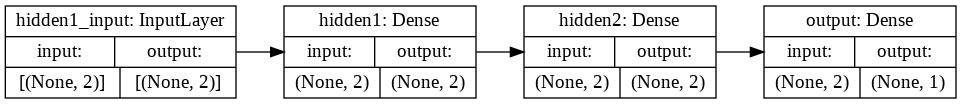

In [44]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=True, dpi=96)

hidden: Denseのoutputを増やすことで平面を分割する直線を増やすことができます。これにより格領域を特徴づける変数を増やすことができます。

## 最適化アルゴリズムと誤差関数の定義

In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## 学習

In [46]:
history = model.fit(train_x, train_t, batch_size=len(train_set), epochs=5000, verbose=0)

## 学習結果の可視化

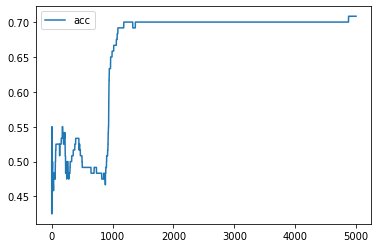

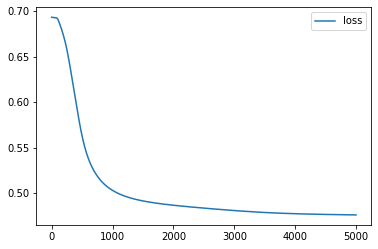

In [41]:
DataFrame({'acc': history.history['acc']}).plot()
DataFrame({'loss': history.history['loss']}).plot()

## 得られた結果の図

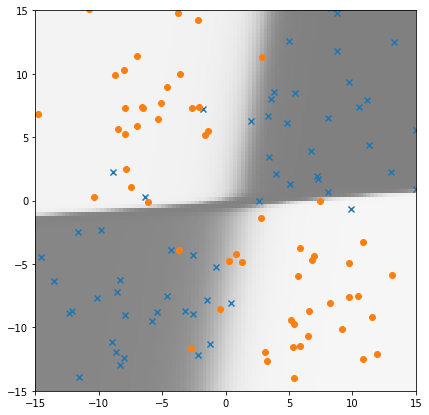

In [47]:
train_set1 = train_set[train_set['t'] == 1]
train_set2 = train_set[train_set['t'] == 0]

fig = plt.figure(figsize=(10, 7))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_ylim([-15, 15])
subplot.set_xlim([-15, 15])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = [[x1, x2] for x2 in np.linspace(-15, 15, 100) for x1 in np.linspace(-15, 15, 100)]
p_vals = model.predict(np.array(locations)).reshape((100, 100))

subplot.imshow(p_vals, origin='lower', extent=(-15, 15, -15, 15), vmin=0, vmax=1, cmap=plt.cm.gray_r, alpha=0.5)